# CTM MILP Model Running Environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputAltPhasing as Model

In [2]:
IMAGE_PATH = 'graphs/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [3]:
parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': 30,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [6]:
def run_model(demand, use=False, flow_weight=0.0, alpha=1.0, log_output=True):
    model = Model(
        demand=demand,
        use_flow_weight=use,
        flow_weight=flow_weight,
        alpha=alpha,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    return dfx, dfy, dfg, dfparams, runtime

In [7]:
dfx, dfy, dfg, dfparams, runtime = run_model(demand=600)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1940 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 128 substitutions.
Reduced MIP has 3482 rows, 1860 columns, and 12232 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (12.67 ticks)
Found incumbent of value 2284.941220 after 0.03 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 142 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.55 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2790 rows, 1668 columns, and 10524 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [35]:
approach = 0

cell_path = [
    (CELL_SOURCE,0,approach),
    (CELL_NORMAL,0,approach),
    (CELL_NORMAL,1,approach),
    (CELL_NORMAL,2,approach),
    (CELL_MOVEMENT,THROUGH_TURN,approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
]

## Comparing cell volumes

In [36]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    
    fig.suptitle(title, fontsize=24)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

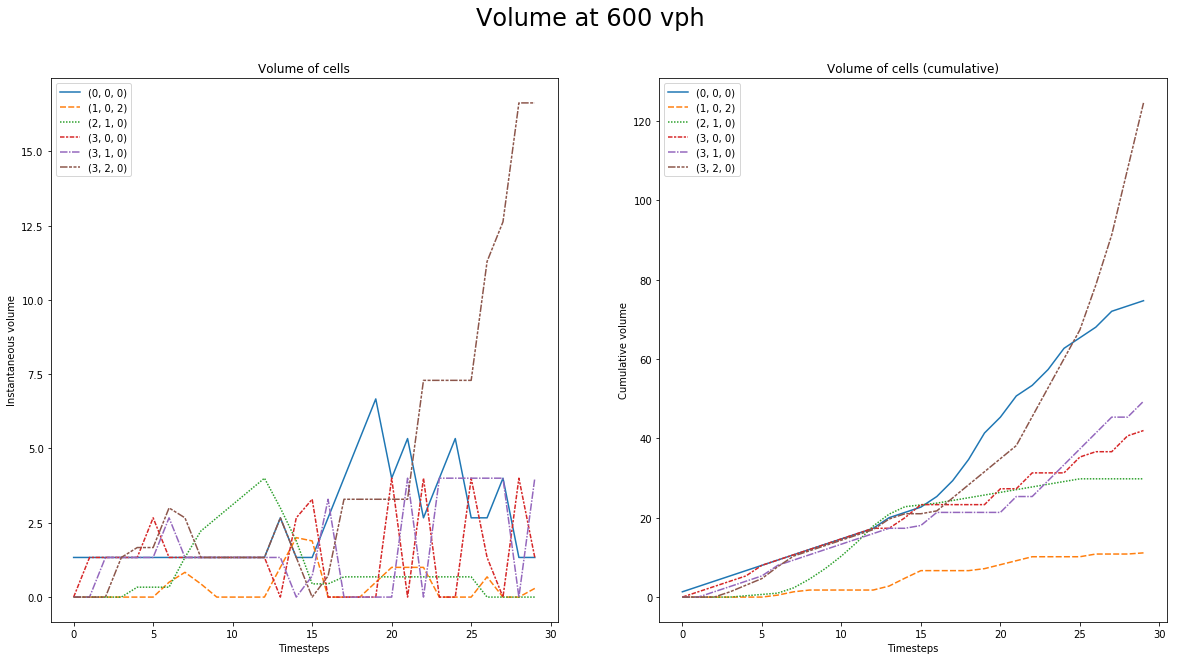

In [37]:
plot_volume(dfx, cell_path, 'Volume at 600 vph', headless=False)

## Comparing flows

In [28]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    
    fig.suptitle(title, fontsize=24)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

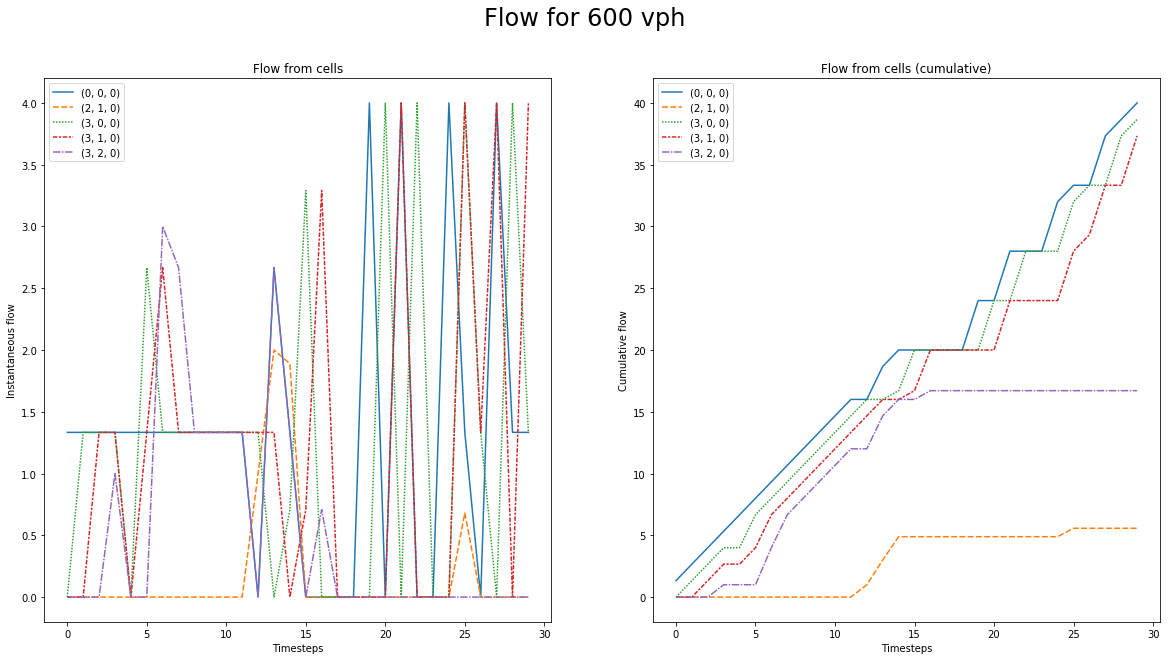

In [38]:
plot_flow(dfy, cell_path, 'Flow for 600 vph', headless=False)

## Comparing specific green time

In [32]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
    
    fig.suptitle(title, fontsize=24)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

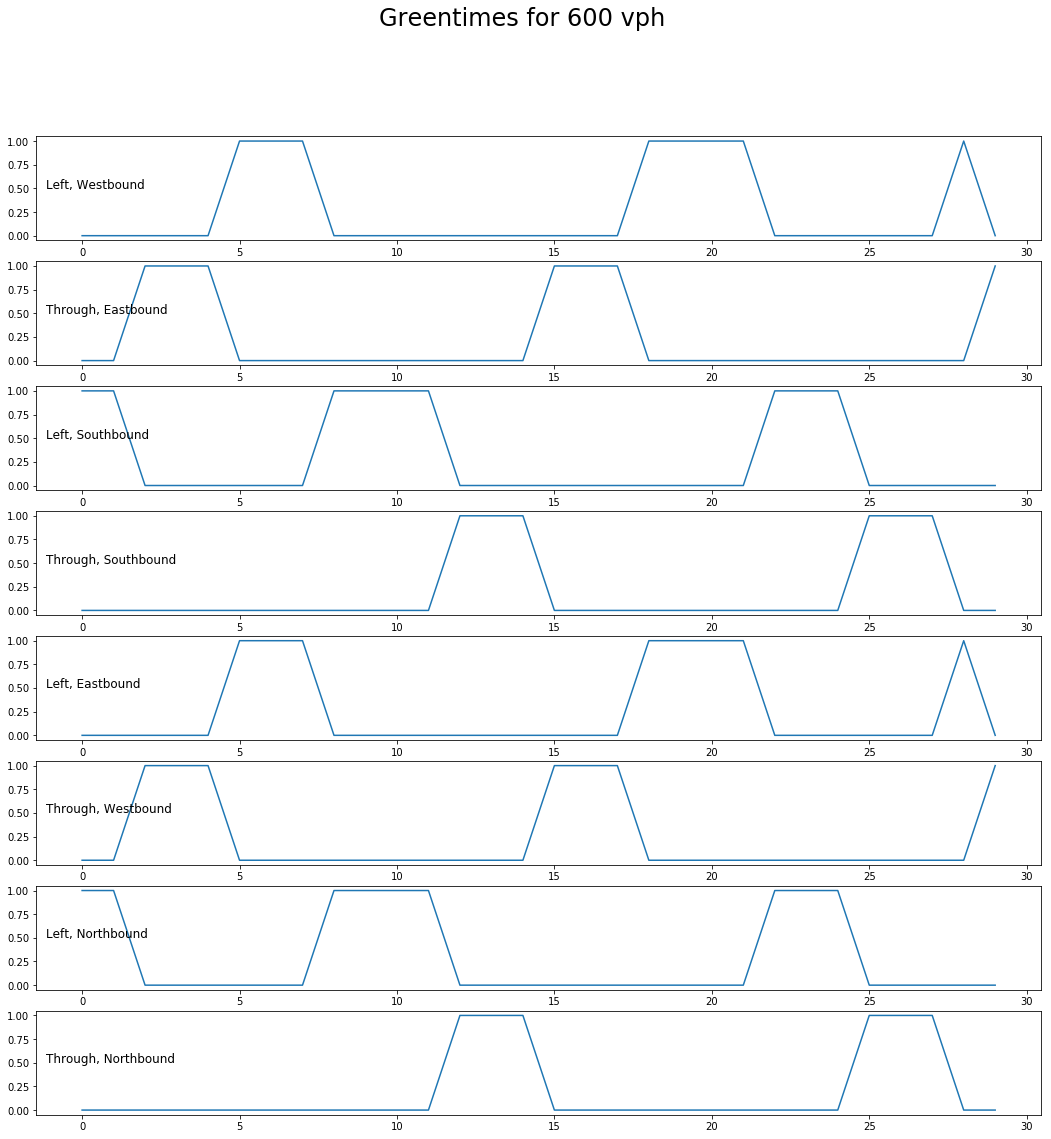

In [39]:
plot_greentime(dfg, 'Greentimes for 600 vph', headless=False)